In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import random
import subprocess as sp
import os
import pickle
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, mark_inset, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [107]:
model = load_model('saved_models/best_syn_vopd_1oct.h5')
train_stats = pd.read_pickle('saved_models/stat_syn_vopd_1oct.pkl')
def norm(x):
    return (x - train_stats['mean']) / (train_stats['std']+0.0000001)

def log_norm(x):
    for col in x.columns:
        x.iloc[:,col] = (x.iloc[:,col] - x.iloc[:,col].min()+1).transform(np.log10)
    return x

train MSE = 45185044.165516


Text(0.5, 1.0, 'train_data_hist')

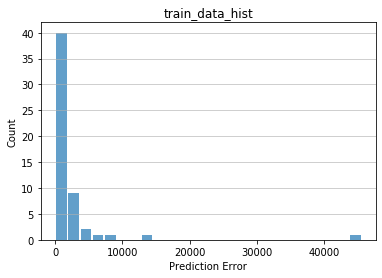

In [108]:
# verifying the model with trained data
X_train = pd.read_csv('latency_model_2010_pso/files/vopd_mapp_features.csv',header=None,error_bad_lines=False)
Y_train = X_train.iloc[:,-1]
X_train.drop(X_train.columns[-1],inplace=True,axis=1)
# X_train.drop(X_train.columns[-1],inplace=True,axis=1)
X = norm(X_train)
X.drop(X.columns[0],inplace=True,axis=1)
Y_pred = model.predict(X).flatten()
train_MSE = np.sum(np.square(Y_pred-Y_train))/Y_train.shape[0]
print('train MSE = %f'%(train_MSE))

#plot histogram
train_error = Y_pred-Y_train
plt.hist(train_error, bins =25,alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title('train_data_hist')
# plt.savefig('train_histr.jpg')

In [109]:
def mapp_syntraff(traffic_type,seed,L,Rs,B):
    random.seed(seed)
    mapp_vec = random.sample(range(1,17),16)
    print('mapping vec',mapp_vec)
    inject_rate = 0.001
    file3 = open("latency_model_2010_pso/files/vopd_mapp.txt","w")   
    file2 = open("analytical_latecy_model_NoC_ver2-master/files/vopd_mapp.txt","w")
    file1 = open('booksim/examples/vopd_mapp.txt','w')
    for i in range(110):
        file3.write('%d\t %s \t %f\n'%(i,str(mapp_vec),inject_rate))
        file2.write('%d\t %s \t %f\n'%(i,str(mapp_vec),inject_rate))
        file1.write('%d\t %s \t %f\n'%(i,str(mapp_vec),inject_rate))
        inject_rate += 0.0015
    file3.close()
    file2.close()
    file1.close()
    
    # ************* begin modify file 2 files/config.txt for diff syn traffic pattern *************#
    with open('analytical_latecy_model_NoC_ver2-master/files/config.txt', 'r') as file:
        # read a list of lines into data
        data = file.readlines()


    # now change the 2nd line, note that you have to add a newline
    data[3] = 'traffic file#\tfiles/'+traffic_type+'\n'
    data[4] = 'routing delay#\t'+Rs+'\n'
    data[6] = 'Packet Size#\t'+L+'\n'
    data[7] = 'Buffer Size#\t'+B+'\n'
  
    # and write everything back
    with open('analytical_latecy_model_NoC_ver2-master/files/config.txt', 'w') as file:
        file.writelines( data )
    #************** end modifying the file **************************************************#
    
    
    open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.txt','w').close()
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/analytical_latecy_model_NoC_ver2-master')
    os.system('./latency_model_2010_2013')
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/')

    with open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.txt','r') as my_file:
        text = my_file.read()
        text = text.replace("    ", " ")
        text = text.replace("[", " ")
        text = text.replace("]", " ")
        text = text.replace(" ",",")
        text = text.replace(",,,",",")
        text = text.replace(",,",",")
        text = text.replace(",,",",")
        text = text.replace(",\n,\n,\n,",'\n')
        text = text.replace('\n,',',')
        text = text.replace('\t',',')
    my_file.close()
    
    open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.csv', 'w').close()
    with open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.csv','w') as analy_file:
        analy_file.write(text)

    
    # ************* begin modify file 3 files/config.txt for diff syn traffic pattern *************#
    with open('latency_model_2010_pso/files/config.txt', 'r') as file_3:
        # read a list of lines into data
        data_3 = file_3.readlines()


    # now change the 2nd line, note that you have to add a newline
    data_3[3] = 'traffic file#\tfiles/'+traffic_type+'\n'
    data_3[4] = 'routing delay#\t'+Rs+'\n'
    data_3[6] = 'Packet Size#\t'+L+'\n'

      
    # and write everything back
    with open('latency_model_2010_pso/files/config.txt', 'w') as file_3:
        file_3.writelines( data_3 )
    #************** end modifying the file **************************************************#
    
    
    open('latency_model_2010_pso/files/vopd_mapp_out.txt','w').close()
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/latency_model_2010_pso')
    open('files/vopd_mapp_features.txt', 'w').close()
    os.system('./latency_mode_2010_updated')
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/')
    

    with open('latency_model_2010_pso/files/vopd_mapp_features.txt','r') as my_file:
        text = my_file.read()
        text = text.replace("    ", " ")
        text = text.replace("[", " ")
        text = text.replace("]", " ")
        text = text.replace(" ",",")
        text = text.replace(",,,",",")
        text = text.replace(",,",",")
        text = text.replace(",,",",")
        text = text.replace(",\n,\n,\n,",'\n')
        text = text.replace('\n,',',')
    my_file.close()
    
    open('latency_model_2010_pso/files/vopd_mapp_features.csv', 'w').close()
    with open('latency_model_2010_pso/files/vopd_mapp_features.csv','w') as analy_file:
        analy_file.write(text)

    with open('latency_model_2010_pso/files/vopd_mapp_out.txt','r') as my_file:
        text = my_file.read()
        text = text.replace("    ", " ")
        text = text.replace("[", " ")
        text = text.replace("]", " ")
        text = text.replace(" ",",")
        text = text.replace(",,,",",")
        text = text.replace(",,",",")
        text = text.replace(",,",",")
        text = text.replace(",\n,\n,\n,",'\n')
        text = text.replace('\n,',',')
        text = text.replace('\t',',')
    my_file.close()
    
    open('latency_model_2010_pso/files/vopd_mapp_out.csv', 'w').close()
    with open('latency_model_2010_pso/files/vopd_mapp_out.csv','w') as analy_file:
        analy_file.write(text)

    # Latency evaluation using booksim simulator
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/booksim/')
#     print(os.getcwd())
        # ************* begin modify file  files/config.txt for diff syn traffic pattern *************#
    with open('examples/anynet_config', 'r') as file:
        # read a list of lines into data
        trff = file.readlines()


    # now change the 2nd line, note that you have to add a newline
    trff[34] =  'vc_buf_size = '+B+';\n'
    trff[73] = 'traffic_file = examples/'+traffic_type+';\n'
   # trff[4] = 'routing delay#\t'+Rs+'\n'
    trff[96] = 'packet_size ='+ L+';\n'


    # and write everything back
    with open('examples/anynet_config', 'w') as file:
        file.writelines(trff)
    #************** end modifying the file **************************************************#
    
    open('examples/vopd_mapp_out.txt', 'w').close()
    sp.call('./pgm_within_pgm',shell=True)

    with open('examples/vopd_mapp_out.txt','r') as my_file:
        text = my_file.read()
        text = text.replace(" \t ", ",")
        text = text.replace("\t\t", ",")
        text = text.replace("\t", ",")
        text = text.replace("[", "")
        text = text.replace("]", " ")
        text = text.replace(" ","")
    my_file.close()
    open('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/booksim_out.csv', 'w').close()
    with open('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training/booksim_out.csv','w') as myfile:
        myfile.write(text)
    my_file.close()
#     print(os.getcwd())
    os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training')
    
    X = pd.read_csv("latency_model_2010_pso/files/vopd_mapp_features.csv",header=None,
                          error_bad_lines=False)
    X.drop(X.columns[-1],inplace=True,axis=1)
    X_norm = norm(X)
    X_norm.drop(X_norm.columns[0],inplace=True,axis=1)
    lpnet = model.predict(X_norm).flatten()
#     print(os.getcwd())

    analy_lat1 = pd.read_csv("analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.csv",header=None,
                             error_bad_lines=False)
    
    analy_lat2 = pd.read_csv("latency_model_2010_pso/files/vopd_mapp_features.csv",header=None,
                             error_bad_lines=False)
    book_lat = pd.read_csv('booksim_out.csv',header=None,error_bad_lines=False)
    lat_ref = analy_lat1.iloc[:,-1]
    lat_pro = analy_lat2.iloc[:,-2]
                           
    analy_lat1.drop(analy_lat1.columns[0],inplace=True,axis=1)
    analy_lat2.drop(analy_lat2.columns[0],inplace=True,axis=1)                      
                           
    return analy_lat1,analy_lat2,lat_pro,lat_ref,book_lat,lpnet

# tornado - seed=1


# trff_files = ['traffic_bitcomplement_16.txt','traffic_bitreverse_16.txt',
# #               'traffic_neighbor_16.txt','traffic_uniform_16.txt','traffic_tornado_16.txt',
# #               'traffic_transpose_16.txt']#,'traffic_uniform_16.txt','traffic_shuffle_16.txt','traffic_vopd.txt']
# trff_files = ['traffic_vopd.txt','traffic_mpeg4.txt','traffic_h264.txt','traffic_tg_16node_1.txt',
#                    'traffic_tg_16node_2.txt','traffic_tg_16node_3.txt']

In [124]:
os.chdir('/home/ram_lak/Ramesh_work/Final_work/mesh4x4_training')
L =  22
Rs = 4
B = 10
cnst = np.full((1,500),500)
analy_lat1,analy_lat2,lat_pro,lat_ref,book_lat,LPNet_pred = mapp_syntraff('traffic_vopd.txt',2,str(L),str(Rs),str(B))
file1 = open('Final_plots_for_pub/Anal_vs_LPNet/tornado_B6_L4.csv','w')
file1.write('sl.no,injection_rate,ref_model,proposed_model,booksim,LPNet\n')
for i in range(len(lat_pro)):
    if  i < len(book_lat.iloc[:,-5]):
        file1.write('%d,%f,%f,%f,%f,%f\n'%(i,analy_lat2.iloc[:,0][i],lat_ref[i],lat_pro[i],book_lat.iloc[:,-4][i],LPNet_pred[i]))
    else:
        file1.write('%d,%f,%f,%f,%f,%f\n'%(i,analy_lat2.iloc[:,0][i],lat_ref[i],lat_pro[i],500,LPNet_pred[i]))
    
    
file1.close()

mapping vec [2, 16, 15, 6, 3, 11, 5, 10, 4, 9, 1, 7, 14, 8, 12, 13]


b'Skipping line 14: expected 22 fields, saw 1747\n'


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f297f075750>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f297f083ed0>)

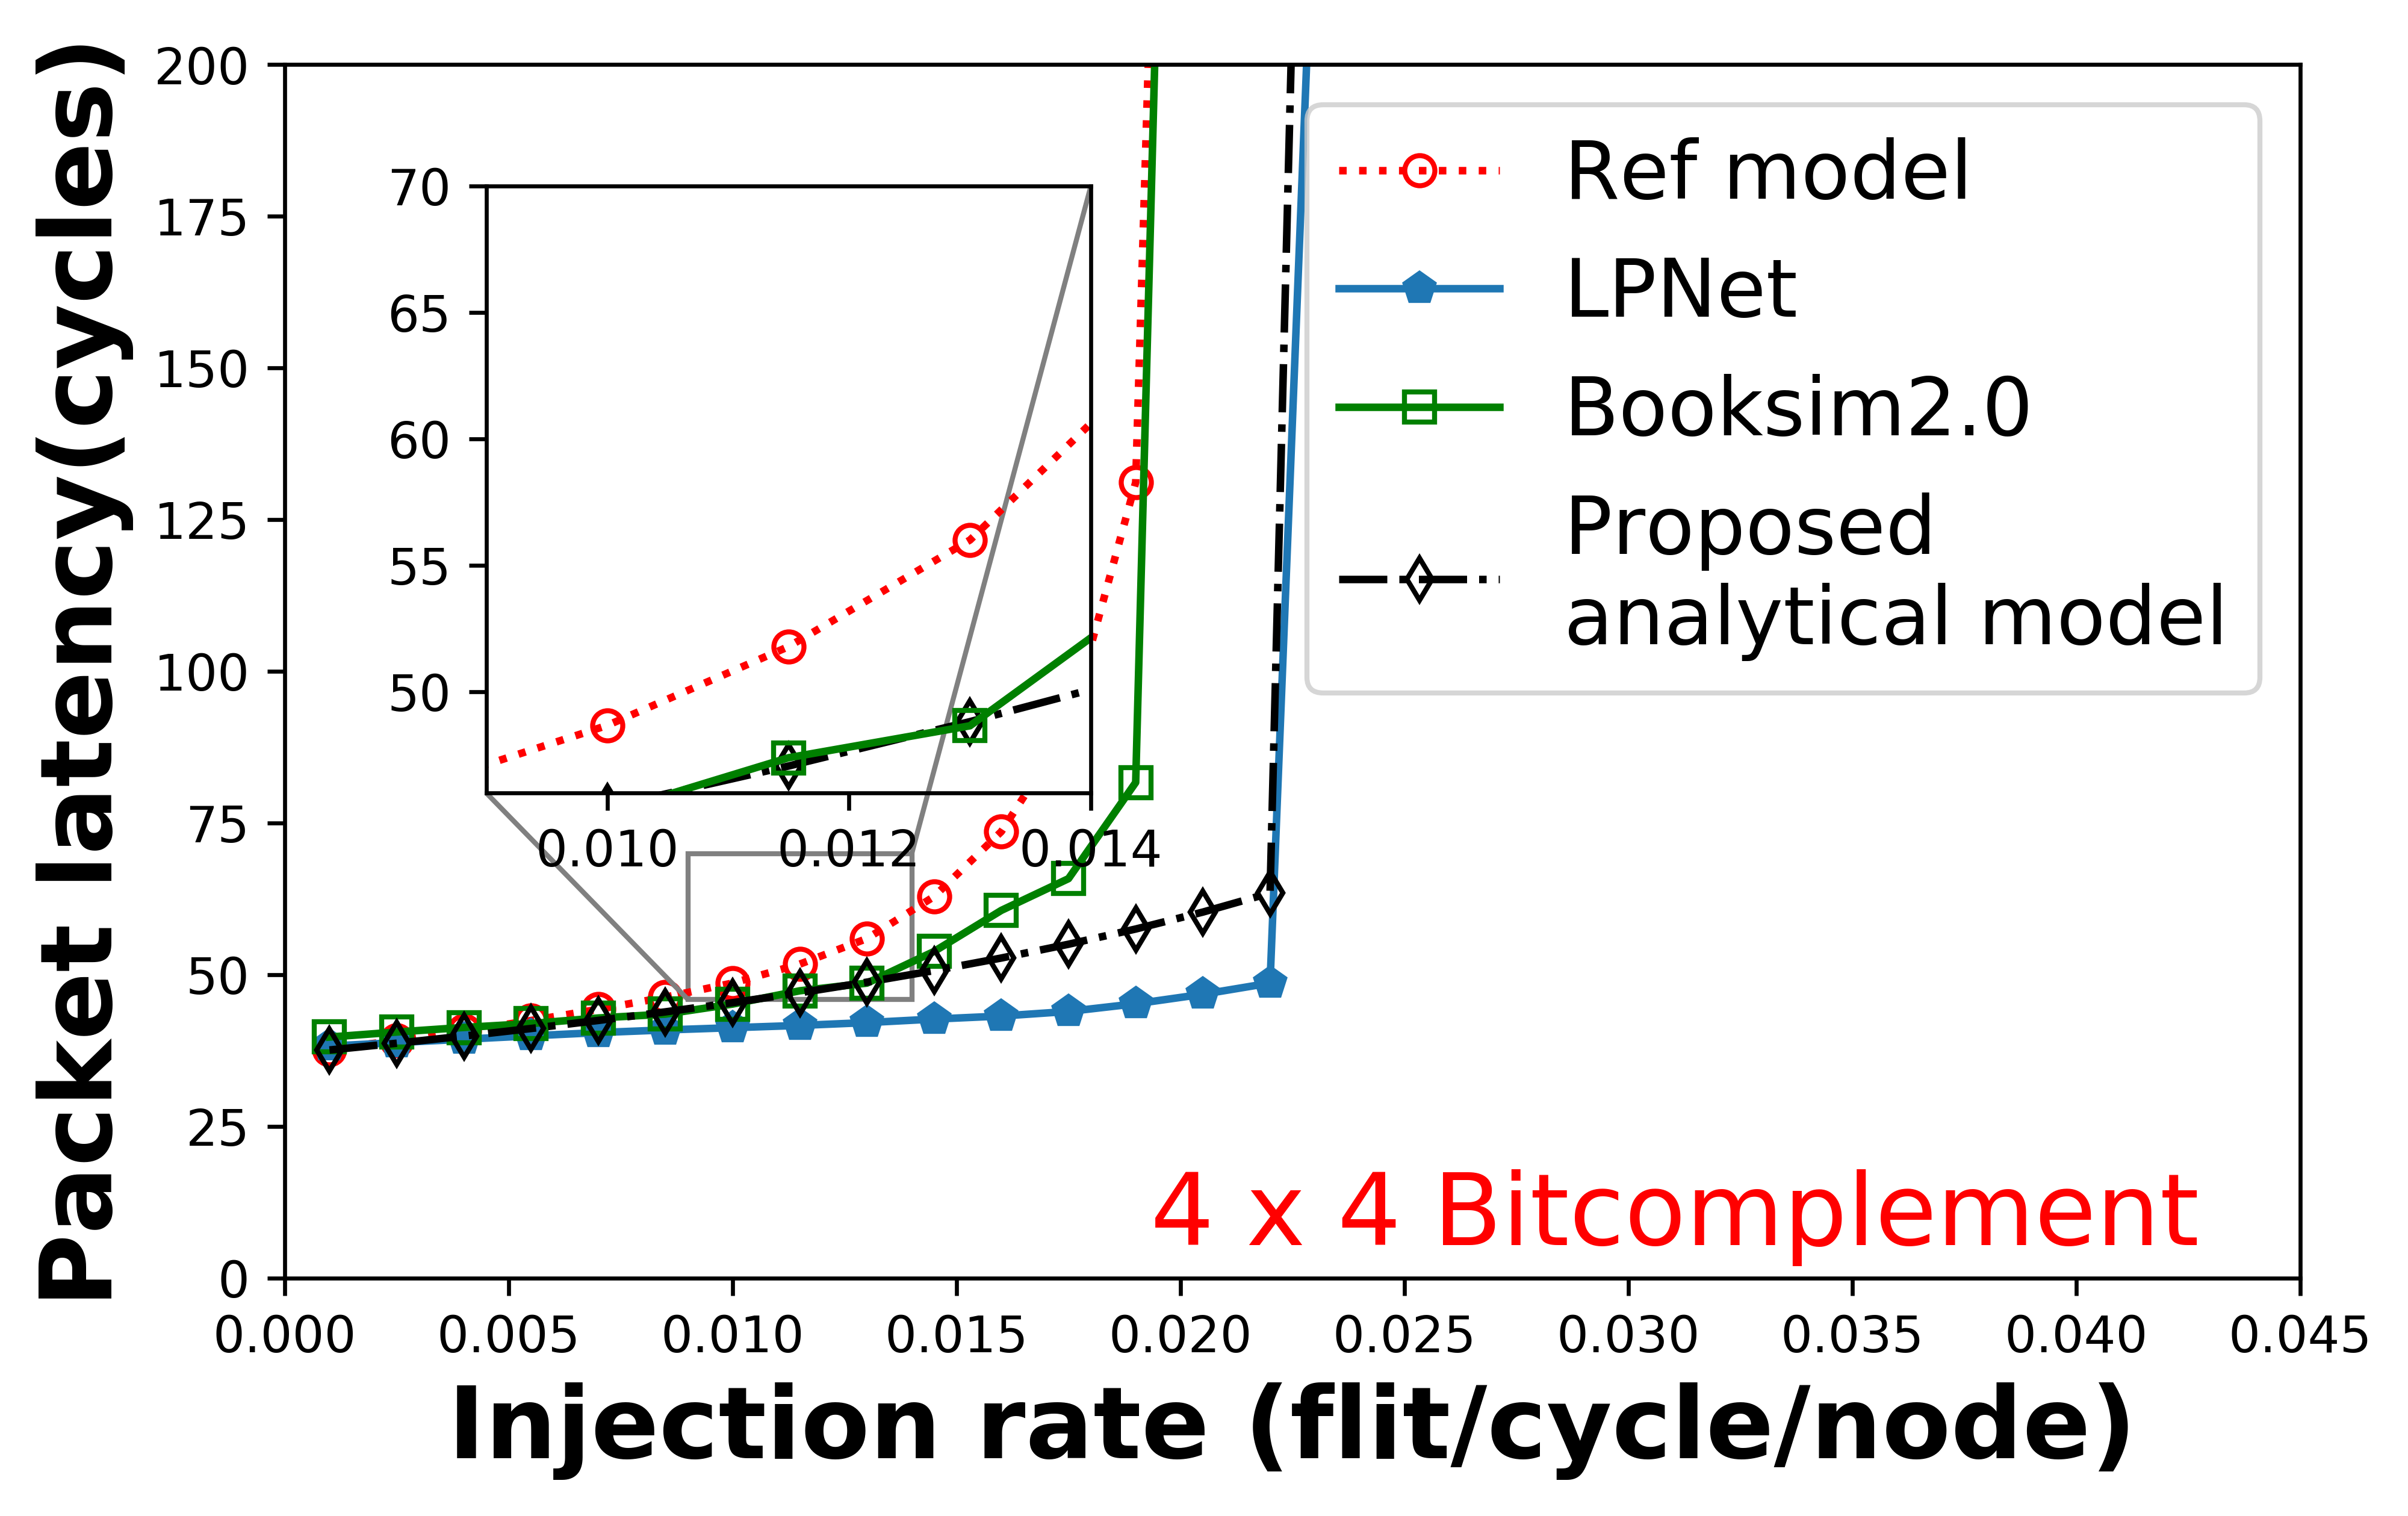

In [125]:
from matplotlib.font_manager import FontProperties
plot_data = pd.read_csv("Final_plots_for_pub/Anal_vs_LPNet/tornado_B6_L4.csv",
                             error_bad_lines=False)
font = FontProperties()
font.set_name('Times New Roman')
marker_style1 = dict(color='r', linestyle=':', marker='o',
                    markersize=6, markerfacecoloralt='tab:red')

marker_style2 = dict(color='k', linestyle='-.', marker='d',
                    markersize=6, markerfacecoloralt='tab:red') 


marker_style3 = dict(color='g', linestyle='-', marker='s',
                    markersize=6, markerfacecoloralt='tab:red') 

    
fig, ax = plt.subplots(figsize=(7.2,4.45),dpi=600)
ax.plot(plot_data['injection_rate'],plot_data['ref_model'],fillstyle='none',**marker_style1,label='Ref model')
ax.plot(plot_data['injection_rate'],plot_data['LPNet'],'-p', label = 'LPNet')
ax.plot(plot_data['injection_rate'],plot_data['booksim'],fillstyle='none',**marker_style3,label = 'Booksim2.0')
ax.plot(plot_data['injection_rate'],plot_data['proposed_model'],fillstyle='none',**marker_style2, label = 'Proposed \nanalytical model')

plt.xlabel('Injection rate (flit/cycle/node)',fontsize=20,fontweight='bold')
plt.ylabel('Packet latency(cycles)',fontsize=20,fontweight='bold')
ax.text(0.95, 0.01, '4 x 4 Bitcomplement', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes,
        color='red', fontsize=20)
# plt.title('sat comparision')
# ax.set_rasterized(True)
ax.set_xlim([0,0.045])
ax.set_ylim([0,200])
plt.legend(loc='upper right',fontsize=16)

# axins = zoomed_inset_axes(ax, 3, loc=9) 
axins = fig.add_axes([0,0,1,1], zorder=10, frameon=True)
axins.set_axes_locator(InsetPosition(ax, [0.1, 0.4, 0.3, 0.5]))

axins.plot(plot_data['injection_rate'],plot_data['ref_model'],fillstyle='none',**marker_style1)
axins.plot(plot_data['injection_rate'],plot_data['proposed_model'],fillstyle='none',**marker_style2)
axins.plot(plot_data['injection_rate'],plot_data['booksim'],fillstyle='none',**marker_style3)
axins.plot(plot_data['injection_rate'],plot_data['LPNet'],'-p')
        
x1, x2, y1, y2 = 0.009, 0.014, 46, 70
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=True)
plt.yticks(visible=True)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5")

In [ ]:
### fig.savefig('Final_plots_for_pub/analy_plots/bitcomplement.pdf',dpi=600,bbox_inches="tight",pad_inches=0)

# fig.savefig('Final_plots_for_pub/analy_plots/bitcomplement.eps', format='eps',dpi=600,bbox_inches="tight",pad_inches=0)

In [134]:
# file1 = open('Final_plots_for_pub/analy_plots/vopd_Rs4_L8.csv','w')
# file1.write('sl.no,injection_rate,ref_model,proposed_model,booksim\n')
# for i in range(len(book_lat.iloc[:,-4])):
#     file1.write('%d,%f,%f,%f,%f\n'%(i,book_lat.iloc[:,-5][i],lat_ref[i],lat_pro[i],book_lat.iloc[:,-4][i]))
# file1.close()

In [44]:
lat_ref

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: 601, dtype: float64

In [101]:
 with open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.txt','r') as my_file:
        text = my_file.read()
        text = text.replace("    ", " ")
        text = text.replace("[", " ")
        text = text.replace("]", " ")
        text = text.replace(" ",",")
        text = text.replace(",,,",",")
        text = text.replace(",,",",")
        text = text.replace(",,",",")
        text = text.replace(",\n,\n,\n,",'\n')
        text = text.replace('\n,',',')
        text = text.replace('\t',',')
    my_file.close()
    
    open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.csv', 'w').close()
    with open('analytical_latecy_model_NoC_ver2-master/files/vopd_mapp_out.csv','w') as analy_file:
        analy_file.write(text)

0     0.0010
1     0.0025
2     0.0040
3     0.0055
4     0.0070
5     0.0085
6     0.0100
7     0.0115
8     0.0130
9     0.0145
10    0.0160
11    0.0175
Name: 17, dtype: float64

In [91]:
analy_lat2.iloc[:,0]

0     0.0010
1     0.0025
2     0.0040
3     0.0055
4     0.0070
5     0.0085
6     0.0100
7     0.0115
8     0.0130
9     0.0145
10    0.0160
11    0.0175
12    0.0190
13    0.0205
14    0.0220
15    0.0235
16    0.0250
17    0.0265
18    0.0280
19    0.0295
20    0.0310
21    0.0325
22    0.0340
23    0.0355
24    0.0370
25    0.0385
26    0.0400
27    0.0415
28    0.0430
29    0.0445
30    0.0460
31    0.0475
32    0.0490
33    0.0505
34    0.0520
35    0.0535
36    0.0550
37    0.0565
38    0.0580
39    0.0595
40    0.0610
41    0.0625
42    0.0640
43    0.0655
44    0.0670
45    0.0685
46    0.0700
47    0.0715
48    0.0730
49    0.0745
50    0.0760
51    0.0775
52    0.0790
53    0.0805
54    0.0820
Name: 1, dtype: float64

In [74]:
cnst


array([[100, 100, 100, 100, 100]])